# **Modelling and Evaluation Notebook**

## Objectives

* The client is interested in gaining insights from the Food Balance Sheet Europe dataset to better understand food production, supply, and consumption patterns across European countries. The goal is to build and evaluate a machine learning model to predict a key variable (e.g., Total Supply) based on features like Production, Import Quantity, and Export Quantity. This model will support decision-making by providing predictive insights into food supply trends, aiding in policy planning and resource management.

## Inputs

* The preprocessed dataset located at data/food_balance_sheet_europe.csv, generated by DataCollection.ipynb.
* Functions from food_balance_app.app_pages.data_loader (load_and_preprocess_data), food_balance_app.app_pages.ml_models (train_model, predict), and food_balance_app.app_pages.visualizations (plot_comparisons).
* Expected columns: ['Production', 'Import Quantity', 'Export Quantity', 'Year', 'Total Supply']
* Python libraries: pandas, numpy, scikit-learn, matplotlib, seaborn

## Outputs

* Printed model performance metrics (R² Score, MAE, RMSE).
* Feature importance dataframe showing the influence of each feature on predictions.
* A scatter plot visualizing predicted vs. actual values for Total Supply.
* Saved model and feature importance files.


## Additional Comments/ Notebook Purpose

* Predict Total Supply using key food balance metrics and evaluate model performance.

## Data Flow
* `DataCollection.ipynb` → `DataVisualisation.ipynb` → `ModellingEvaluation.ipynb` 

 



---

# Import Packages

### Install Dependencies

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\User\\Documents\\food sheet prediction\\food-sheet-prediction\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\User\\Documents\\food sheet prediction\\food-sheet-prediction'

---

### **Set Data Directory**

---

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns
print("All required libraries imported successfully!")



All required libraries imported successfully!


### Data Loading

In [7]:
data_path = Path().resolve().parent / 'data' / 'food_balance_sheet_europe.csv'
df = pd.read_csv(r"C:\Users\User\Documents\food sheet prediction\food-sheet-prediction\data\food_balance_sheet_europe.csv")
print(f"Data loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")

Data loaded successfully with 1214 rows and 14 columns


### Data Preparation

In [ ]:
"""
# Food Balance Sheet Prediction - Modeling & Evaluation

**Actual Columns in Your Data**:
['Domain Code', 'Domain', 'Country Code', 'Country', 'Element Code', 'Element', 
 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description']
"""


# Cell 3: Data Preparation (Corrected)
print("Available columns in your data:")
print(df.columns.tolist())

# Identify which elements correspond to our metrics
production_data = df[df['Element'] == 'Production']
import_data = df[df['Element'] == 'Import Quantity']
export_data = df[df['Element'] == 'Export Quantity']

print("\nFound these elements in your 'Element' column:")
print(df['Element'].unique())

# Create a consolidated dataframe
metrics_df = pd.DataFrame({
    'Country': df['Country'],
    'Year': df['Year'],
    'Production': df.loc[df['Element'] == 'Production', 'Value'],
    'Import_Quantity': df.loc[df['Element'] == 'Import Quantity', 'Value'],
    'Export_Quantity': df.loc[df['Element'] == 'Export Quantity', 'Value'],
    'Total_Supply': df.loc[df['Element'] == 'Domestic supply quantity', 'Value']
})

# Forward-fill missing values by country and year
metrics_df = metrics_df.groupby(['Country', 'Year']).ffill()

print("\nData preparation complete:")
print("New dataframe shape:", metrics_df.shape)
print("Columns in prepared data:", metrics_df.columns.tolist())
print("\nSample of prepared data:")
display(metrics_df.head())

Available columns in your data:
['Domain Code', 'Domain', 'Country Code', 'Country', 'Element Code', 'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description']

Found these elements in your 'Element' column:
['Total Population - Both sexes' 'Production' 'Import Quantity'
 'Stock Variation' 'Export Quantity' 'Domestic supply quantity' 'Feed'
 'Seed' 'Losses' 'Processing' 'Other uses' 'Food'
 'Food supply quantity (kg/capita/yr)' 'Food supply (kcal/capita/day)'
 'Protein supply quantity (g/capita/day)'
 'Fat supply quantity (g/capita/day)']

Data preparation complete:
New dataframe shape: (1214, 4)
Columns in prepared data: ['Production', 'Import_Quantity', 'Export_Quantity', 'Total_Supply']

Sample of prepared data:


,Production,Import_Quantity,Export_Quantity,Total_Supply
0,NaN,NaN,NaN,NaN
1,226089.0,NaN,NaN,NaN
2,226089.0,45338.0,NaN,NaN
3,226089.0,45338.0,NaN,NaN
4,226089.0,45338.0,91363.0,NaN


---

### Model Training Function

In [ ]:
# %% [markdown]
"""
## Model Training (Cell 4 - Corrected)
"""
# %%
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


print("Columns in metrics_df:", metrics_df.columns.tolist())

# Prepare features and target - using only columns that exist
available_features = []
potential_features = ['Production', 'Import_Quantity', 'Export_Quantity', 'Year']
for feat in potential_features:
    if feat in metrics_df.columns:
        available_features.append(feat)
    else:
        print(f"Warning: {feat} not found in dataframe")

target = 'Total_Supply' if 'Total_Supply' in metrics_df.columns else None

if not target:
    print("Error: Target column 'Total_Supply' not found")
    print("Available columns:", metrics_df.columns.tolist())
else:
    # Remove rows with missing values in our features/target
    modeling_df = metrics_df.dropna(subset=available_features + [target])
    
    if len(modeling_df) == 0:
        print("Error: No complete records available after removing missing values")
    else:
        X = modeling_df[available_features]
        y = modeling_df[target]

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        print("\nModel trained successfully!")
        print(f"Used {len(modeling_df)} complete records for modeling")
        print(f"Features used: {available_features}")
        print(f"Target variable: {target}")
        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Columns in metrics_df: ['Production', 'Import_Quantity', 'Export_Quantity', 'Total_Supply']

Model trained successfully!
Used 1209 complete records for modeling
Features used: ['Production', 'Import_Quantity', 'Export_Quantity']
Target variable: Total_Supply
Training samples: 967, Test samples: 242


### Model Evaluation

In [19]:
# %% [markdown]
"""
## Model Evaluation (Cell 5)
"""
# %%
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
metrics = {
    'R² Score': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
}

# Feature importance
importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== Model Performance ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

print("\n=== Feature Importance ===")
display(importance)

# %%
# %% [markdown]


=== Model Performance ===
R² Score: 0.8593
MAE: 4008.5841
RMSE: 13652.1523

=== Feature Importance ===


,Feature,Importance
2,Export_Quantity,0.763025
0,Production,0.208665
1,Import_Quantity,0.028310


### Visualization 

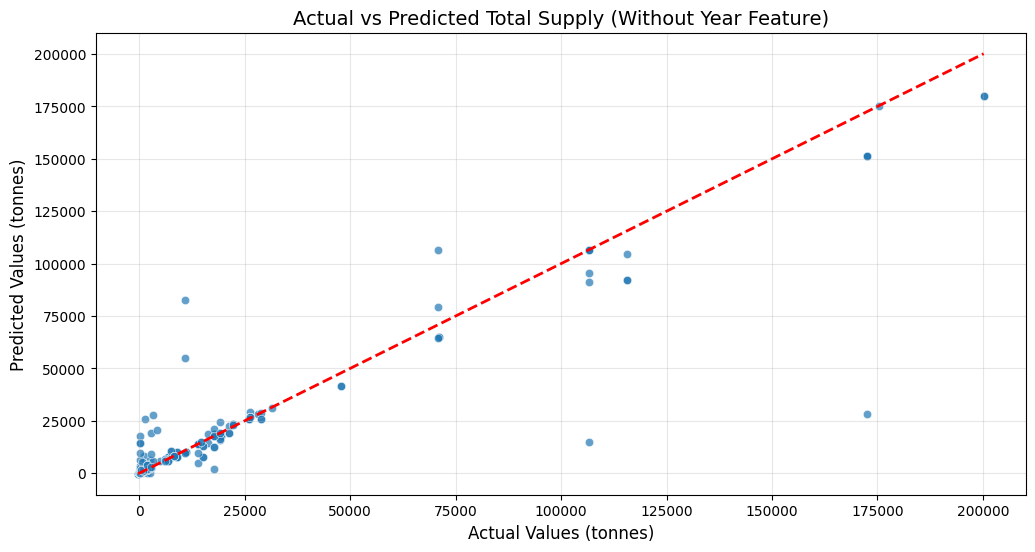

C:\Users\User\AppData\Local\Temp\ipykernel_2644\1601018066.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


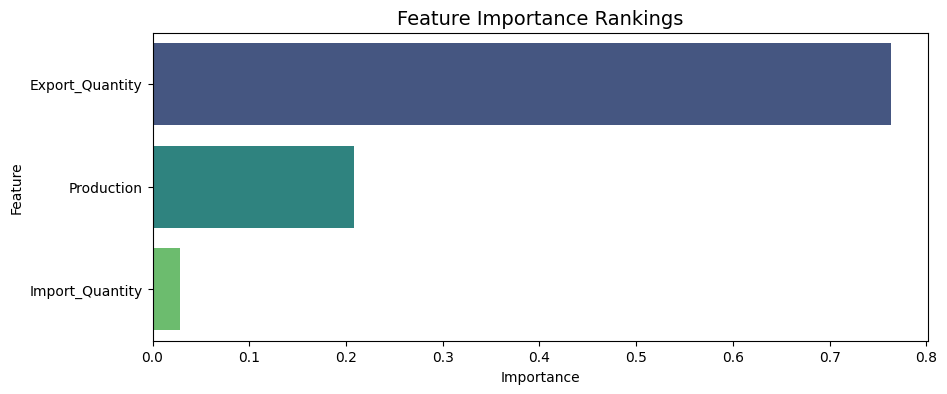

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Actual vs Predicted plot
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         'r--', lw=2)
plt.title('Actual vs Predicted Total Supply (Without Year Feature)', fontsize=14)
plt.xlabel('Actual Values (tonnes)', fontsize=12)
plt.ylabel('Predicted Values (tonnes)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Feature Importance Rankings', fontsize=14)
plt.show()

### Export Results

In [ ]:
import joblib
from datetime import datetime
import os

# Create output directory 
output_dir = 'model_output'
os.makedirs(output_dir, exist_ok=True)

# Generate timestamp for files
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save model
model_path = os.path.join(output_dir, f"food_supply_model_{timestamp}.pkl")
joblib.dump(model, model_path)

# Save predictions with actuals
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Production': X_test['Production'],
    'Import_Quantity': X_test['Import_Quantity'],
    'Export_Quantity': X_test['Export_Quantity']
})
results_path = os.path.join(output_dir, f"predictions_{timestamp}.csv")
results_df.to_csv(results_path, index=False)

print(f"Model saved to: {model_path}")
print(f"Predictions saved to: {results_path}")

Model saved to: model_output\food_supply_model_20250416_193825.pkl
Predictions saved to: model_output\predictions_20250416_193825.csv


### Enhanced Model Evaluation 


=== Extended Model Performance ===
R² Score: 0.8593
MAE: 4008.5841
RMSE: 13652.1523
Mean Residual: 614.3770
Residual Std: 13666.5871
Skewness: 5.2654
Kurtosis: 60.5564


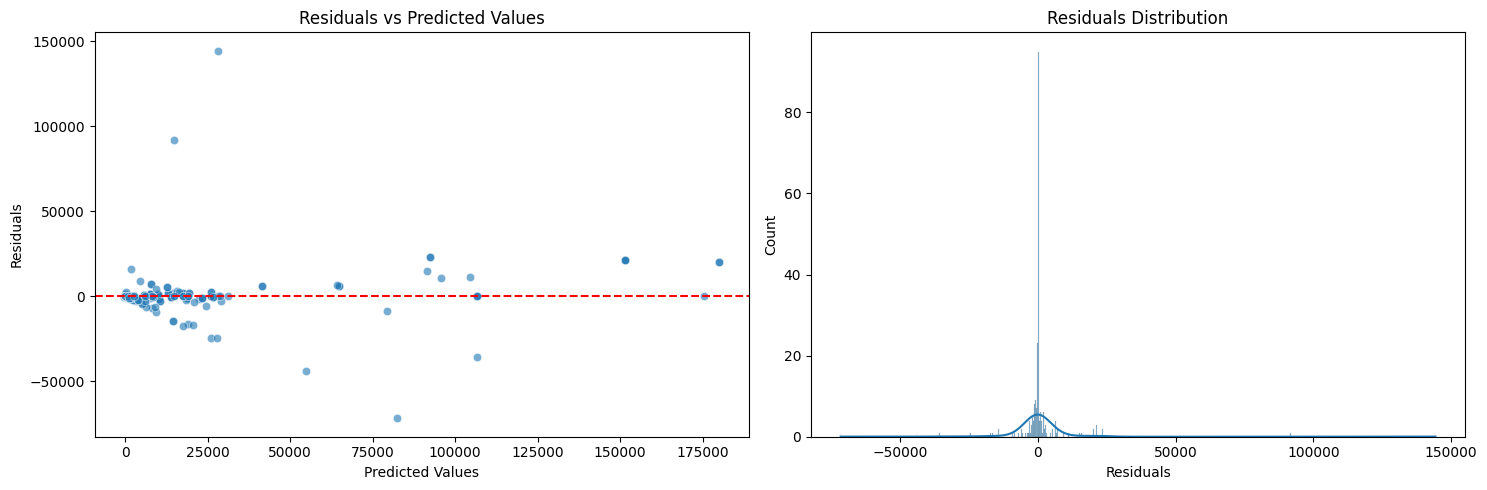

In [22]:
from scipy import stats

# Calculate additional metrics
residuals = y_test - y_pred
metrics.update({
    'Mean Residual': residuals.mean(),
    'Residual Std': residuals.std(),
    'Skewness': stats.skew(residuals),
    'Kurtosis': stats.kurtosis(residuals)
})

print("\n=== Extended Model Performance ===")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# %%
# Cell 5b: Residual Analysis
plt.figure(figsize=(15, 5))

# Residuals plot
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

# Residuals distribution
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()


### Enhanced Visualizations

C:\Users\User\AppData\Local\Temp\ipykernel_2644\1967795364.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')


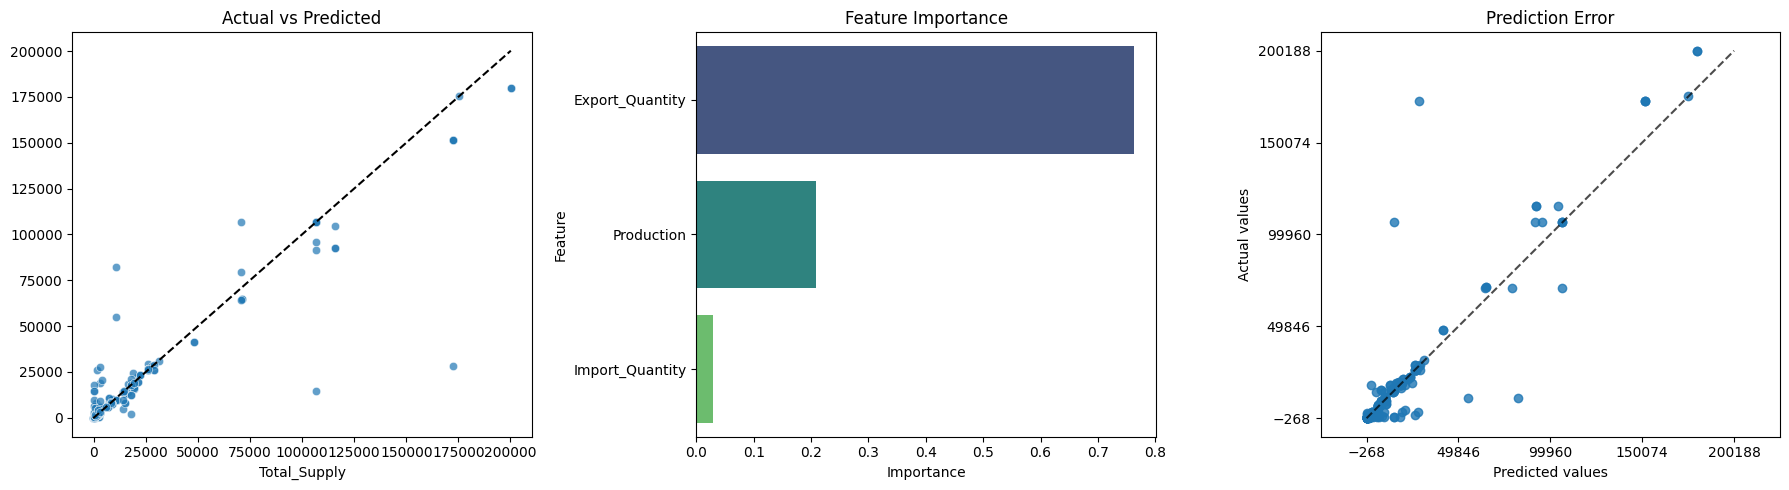

In [ ]:
plt.figure(figsize=(18, 5))

# Actual vs Predicted with country info 
if 'Country' in metrics_df.columns:
    test_countries = metrics_df.loc[X_test.index, 'Country']
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred, hue=test_countries, alpha=0.7, palette='tab10')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.title('Actual vs Predicted by Country')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
    plt.title('Actual vs Predicted')

# Feature importance with confidence
plt.subplot(1, 3, 2)
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Feature Importance')

# Prediction error plot
plt.subplot(1, 3, 3)
from sklearn.metrics import PredictionErrorDisplay
PredictionErrorDisplay.from_predictions(y_test, y_pred, kind="actual_vs_predicted", ax=plt.gca())
plt.title('Prediction Error')

plt.tight_layout()
plt.show()

### Model Comparison 

In [24]:
def compare_models(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LinearRegression
    from xgboost import XGBRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    
    models = {
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'Linear Regression': LinearRegression()
    }
    
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results.append({
            'Model': name,
            'R²': r2_score(y_test, y_pred),
            'MAE': mean_absolute_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
        })
    
    return pd.DataFrame(results)

model_comparison = compare_models(X_train, y_train, X_test, y_test)
print("\n=== Model Comparison ===")
display(model_comparison.sort_values('R²', ascending=False))


=== Model Comparison ===


,Model,R²,MAE,RMSE
1,XGBoost,0.881477,3324.623303,12529.505103
2,Gradient Boosting,0.876826,4168.801539,12772.957679
0,Random Forest,0.859286,4008.584106,13652.152314
3,Linear Regression,0.671695,8939.623814,20853.151805


### Final Export

In [25]:
import json

# Save full model report
report = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features': available_features,
    'target': target,
    'metrics': metrics,
    'model_params': model.get_params(),
    'data_stats': {
        'n_samples': len(modeling_df),
        'train_samples': len(X_train),
        'test_samples': len(X_test)
    }
}

report_path = os.path.join(output_dir, f"model_report_{timestamp}.json")
with open(report_path, 'w') as f:
    json.dump(report, f, indent=4)

print(f"Full report saved to: {report_path}")

Full report saved to: model_output\model_report_20250416_193825.json


# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

###  Create Project Structure

In [27]:
import os

try:
    folder_name = 'outputs'  
    os.makedirs(folder_name, exist_ok=True)
    print(f"✅ Folder '{folder_name}' created (or already exists).")
except Exception as e:
    print(f"❌ Error: {e}")

✅ Folder 'outputs' created (or already exists).
